In [1]:
import pandas as pd
import json
import glob

# Simulator CartPole

In [2]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

class InvertedPendulum:
    def __init__(self, m1=5.0, m2=1.0, l=2.0, g=9.81, cr=0.0, ca=0.0, x0=None):
        self.m1 = m1  # Cart mass
        self.m2 = m2  # Pendulum mass
        self.l = l    # Pendulum length
        self.g = g    # Gravity
        self.c_cart = cr  # Cart friction coefficient (renamed from cv to cr)
        self.c_pendulum = ca  # Pendulum friction coefficient
        self.x0 = x0

    def dynamics(self, x, t, u):
        x1, x2, x3, x4 = x
        cosx3, sinx3 = np.cos(x3), np.sin(x3)
        total_force = u - self.c_cart * x2  # Cambiado de c_carro a c_cart

        dx1dt = x2
        dx2dt = (total_force + self.m2 * self.l * x4**2 * sinx3 - self.m2 * self.g * sinx3 * cosx3) / (self.m1 + self.m2 * (1 - cosx3**2))
        dx3dt = x4
        dx4dt = (-total_force * cosx3 + (self.m1 + self.m2) * self.g * sinx3 - self.m2 * self.l * x4**2 * sinx3 * cosx3 - self.c_cart * x2) / (self.l * (self.m1 + self.m2 * (1 - cosx3**2)))

        return [dx1dt, dx2dt, dx3dt, dx4dt]

    def update(self, x, t, dt, u):
        y = odeint(self.dynamics, x, [t, t + dt], args=(u,))
        y[1][2] = self.normalize_angle(y[1][2])
        return y[1]
    
    def normalize_angle(self, angle):
        return (angle + np.pi) % (2 * np.pi) - np.pi

In [3]:
class PIDController:
    def __init__(self, kp, ki, kd, setpoint, dt):
        self.initial_kp, self.initial_ki, self.initial_kd = kp, ki, kd
        self.kp, self.ki, self.kd = kp, ki, kd
        self.prev_kp = kp  # Add previous gains
        self.prev_ki = ki  # Add previous gains
        self.setpoint = setpoint
        self.dt = dt
        self.prev_error = 0.0
        self.derivative_error = 0.0
        self.prev_integral_error = 0.0
        self.integral_error = 0.0

    def compute(self, error):
        #self.integral_error += ((self.prev_kp * self.prev_error) + (self.prev_ki * self.prev_integral_error * self.dt) - (self.kp * error))/self.ki if self.ki!=0 else 0
        self.integral_error += error * self.dt
        self.derivative_error = (error - self.prev_error) / self.dt
        
        u = (self.kp * error) + (self.ki * self.integral_error) + (self.kd * self.derivative_error)
        
        self.prev_kp = self.kp
        self.prev_ki = self.ki
        self.prev_error = error
        self.prev_integral_error = self.integral_error
        return u

In [9]:
def simulation_CartPole(new_kp=50.0,new_ki=10.0,new_kd=20.0):
    setpoint = 0.0
    dt = 0.001
    timesteps = 5000
    # Crear una instancia del Péndulo Invertido
    pendulum = InvertedPendulum(x0=[0, 0, 0.0873, 0]) #0.1746
    # Crear una nueva instancia del Controlador PID con las nuevas ganancias
    pid = PIDController(kp=new_kp, ki=new_ki, kd=new_kd, setpoint=setpoint, dt=dt)
    
    # Reiniciar las listas de resultados
    time_history = [0]
    cart_position_history = [x[0] for x in [pendulum.x0]]
    cart_velocity_history = [x[1] for x in [pendulum.x0]]
    pendulum_angle_history = [x[2] for x in [pendulum.x0]]
    pendulum_vel_history = [x[3] for x in [pendulum.x0]]
    force_history  = [0]
    
    # Reiniciar el estado
    x = [0, 0, 0.0873, 0]
    
    # Ejecutar la simulación nuevamente
    for step in range(1, timesteps + 1):
        current_time = step * dt
        
        # Calcular el error (ángulo actual - setpoint)
        error = x[2] - setpoint
        
        # Calcular la fuerza de control utilizando el PID
        u = pid.compute(error)
        
        # Actualizar el estado del péndulo invertido
        x = pendulum.update(x, current_time, dt, u)
        
        # Almacenar los datos
        time_history.append(current_time)
        cart_position_history.append(x[0])
        cart_velocity_history.append(x[1])
        pendulum_angle_history.append(x[2])
        pendulum_vel_history.append(x[3])
        force_history.append(u)
    
    
    # Crear los gráficos nuevamente
    fig, axs = plt.subplots(5, 1, figsize=(8, 12))
    
    
    t_adjust = 5000 ###
    
    # Gráfico de Ángulo vs. Tiempo
    axs[0].plot(time_history[:t_adjust], pendulum_angle_history[:t_adjust], label='Ángulo', color='b')
    axs[0].axhline(y=0.001, color='r', linestyle='--', label='Setpoint')
    axs[0].set_xlabel('Tiempo (s)', fontsize=12)
    axs[0].set_ylabel('Ángulo (rad)', fontsize=12)
    axs[0].set_title('Ángulo del Péndulo vs. Tiempo', fontsize=14)
    axs[0].legend(fontsize=12)
    axs[0].grid(True)

    # Gráfico de Vel_angular vs. Tiempo
    axs[1].plot(time_history[:t_adjust], pendulum_vel_history[:t_adjust], label='Velocidad angular', color='b')
    axs[1].axhline(y=0.005, color='r', linestyle='--', label='Setpoint')
    axs[1].set_xlabel('Tiempo (s)', fontsize=12)
    axs[1].set_ylabel('Velocidad angular (rad/s)', fontsize=12)
    axs[1].set_title('Velocidad angular del Péndulo vs. Tiempo', fontsize=14)
    axs[1].legend(fontsize=12)
    axs[1].grid(True)
    
    # Gráfico de Posición del Carro vs. Tiempo
    axs[2].plot(time_history[:t_adjust], cart_position_history[:t_adjust], label='Posición del Carro', color='g')
    axs[2].set_xlabel('Tiempo (s)', fontsize=12)
    axs[2].set_ylabel('Posición (m)', fontsize=12)
    axs[2].set_title('Posición del Carro vs. Tiempo', fontsize=14)
    axs[2].legend(fontsize=12)
    axs[2].grid(True)

    # Gráfico de Velocidad del Carro vs. Tiempo
    axs[3].plot(time_history[:t_adjust], cart_velocity_history[:t_adjust], label='Velocidad del Carro', color='g')
    axs[3].set_xlabel('Tiempo (s)', fontsize=12)
    axs[3].set_ylabel('Velocidad del carro (m/s)', fontsize=12)
    axs[3].set_title('Velocidad del Carro vs. Tiempo', fontsize=14)
    axs[3].legend(fontsize=12)
    axs[3].grid(True)
    
    # Gráfico de Fuerza vs. Tiempo
    axs[4].plot(time_history[:t_adjust], force_history[:t_adjust], label='Fuerza de Control (u)', color='m')
    axs[4].set_xlabel('Tiempo (s)', fontsize=12)
    axs[4].set_ylabel('Fuerza (N)', fontsize=12)
    axs[4].set_title('Fuerza de Control vs. Tiempo)', fontsize=14)
    axs[4].legend(fontsize=12)
    axs[4].grid(True)
    
    # Ajustar el layout y mostrar los gráficos
    plt.tight_layout()
    return plt.show()

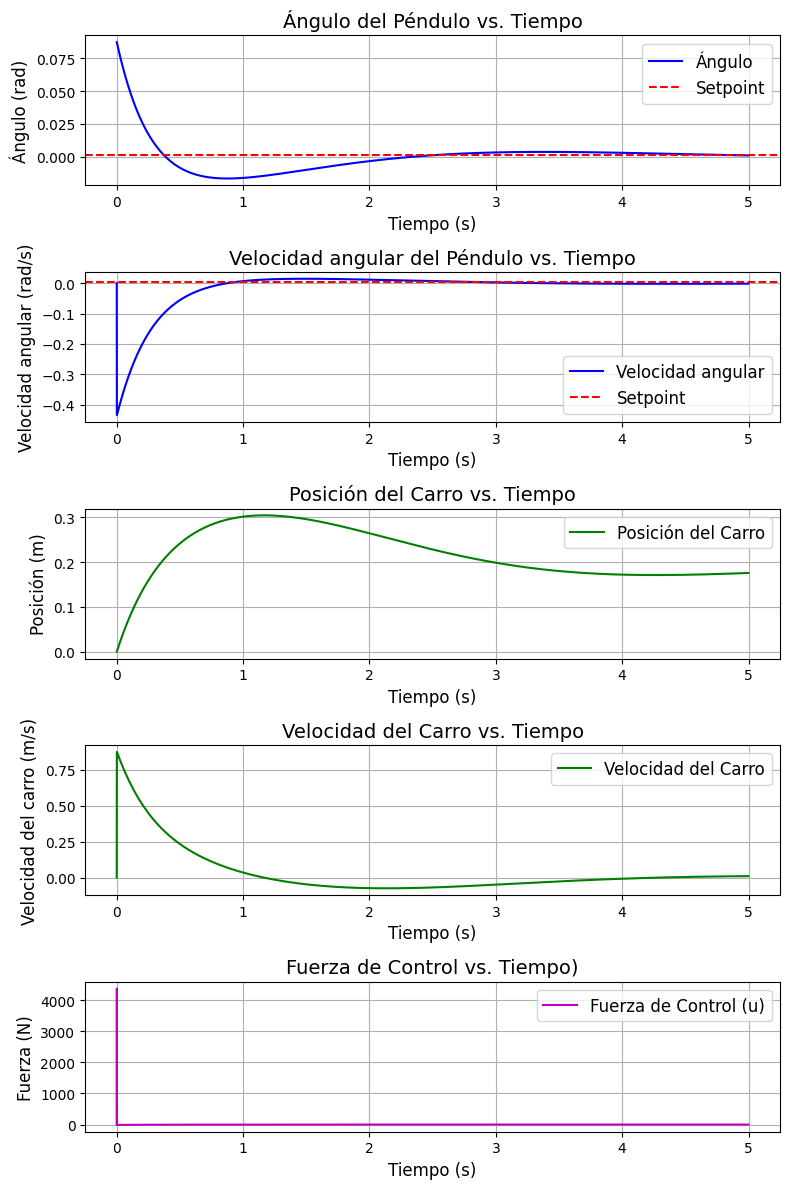

In [27]:
# Definir nuevas ganancias PID
new_kp = 120 #  35  #75#65#40.0
new_ki = 50 #  22.5 32.5  #25#5#15.0
new_kd = 50 #    #15#20.0
simulation_CartPole(new_kp=new_kp,new_ki=new_ki,new_kd=new_kd)

In [ ]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import json
from pathlib import Path
from typing import List, Dict, Any, Optional
import matplotlib.pyplot as plt

class SimulationVisualizer:
    def __init__(self, data_path: str):
        """
        Inicializa el visualizador de simulaciones.
        
        Args:
            data_path (str): Ruta al directorio que contiene los archivos de simulación
        """
        self.data_path = Path(data_path)
        self.data = self._load_data()
        
    def _load_data(self) -> Dict:
        """
        Carga los datos de la simulación desde los archivos JSON.
        
        Returns:
            Dict: Datos de la simulación
        """
        # Cargar datos de simulación
        episodes_data = []
        for file in sorted(self.data_path.glob("episode_*.json")):
            with open(file, 'r') as f:
                episodes_data.append(json.load(f))
                
        # Cargar metadata si existe
        metadata = {}
        metadata_path = self.data_path / 'metadata.json'
        if metadata_path.exists():
            with open(metadata_path, 'r') as f:
                metadata = json.load(f)
                
        return {
            'simulation_data': episodes_data,
            'metadata': metadata
        }
    
    def plot_episode_metrics(self):
        """
        Genera gráficos de métricas por episodio: recompensa acumulada, 
        tiempo final y rendimiento.
        """
        episodes_data = self.data['simulation_data']
        
        # Extraer datos
        episode_data = [(ep.get('episode'), 
                        ep.get('cumulative_reward', [0])[-1],
                        ep.get('time', [0])[-1]) 
                       for ep in episodes_data]
        
        # Ordenar por número de episodio
        episode_data.sort(key=lambda x: x[0])
        episode_numbers = [x[0] for x in episode_data]
        cumulative_rewards = [x[1] for x in episode_data]
        final_times = [x[2] for x in episode_data]
        
        # Calcular performance
        performance = [r/t if t != 0 else 0 for r, t in zip(cumulative_rewards, final_times)]
        
        # Crear subplots
        fig = go.Figure()
        titles = ['Cumulative Reward', 'Final Time', 'Performance']
        data_sets = [cumulative_rewards, final_times, performance]
        
        for i, (title, data) in enumerate(zip(titles, data_sets)):
            fig.add_trace(go.Scatter(
                x=episode_numbers,
                y=data,
                mode='lines+markers',
                name=title,
                marker=dict(size=4),
                line=dict(width=1)
            ))
            
            # Actualizar layout
            fig.update_layout(
                title=f"Episode Metrics",
                xaxis_title="Episode",
                yaxis_title="Value",
                plot_bgcolor='white',
                showlegend=True,
                height=600,
                width=1000
            )
            
            # Actualizar ejes
            fig.update_xaxes(
                showgrid=True,
                gridwidth=1,
                gridcolor='lightgray',
                zeroline=True,
                zerolinewidth=1,
                zerolinecolor='lightgray'
            )
            fig.update_yaxes(
                showgrid=True,
                gridwidth=1,
                gridcolor='lightgray',
                zeroline=True,
                zerolinewidth=1,
                zerolinecolor='lightgray'
            )
            
        return fig
    
    def plot_heatmap(self, x_param: str, y_param: str, bin_size: int = 200,
                     episode_range: Optional[tuple] = None):
        """
        Genera un heatmap de dos variables seleccionadas.
        
        Args:
            x_param (str): Nombre del parámetro para el eje X
            y_param (str): Nombre del parámetro para el eje Y
            bin_size (int): Número de bins para el heatmap
            episode_range (tuple): Rango de episodios a incluir (inicio, fin)
        """
        episodes_data = self.data['simulation_data']
        
        # Filtrar episodios si se especifica un rango
        if episode_range:
            start, end = episode_range
            episodes_data = [ep for ep in episodes_data 
                           if start <= ep['episode'] <= end]
        
        # Recopilar datos
        x_data = []
        y_data = []
        for episode in episodes_data:
            x_values = episode.get(x_param, [])
            y_values = episode.get(y_param, [])
            if not isinstance(x_values, list): x_values = [x_values]
            if not isinstance(y_values, list): y_values = [y_values]
            x_data.extend(x_values)
            y_data.extend(y_values)
            
        # Crear heatmap
        heatmap, xedges, yedges = np.histogram2d(x_data, y_data, bins=bin_size)
        
        fig = go.Figure(data=go.Heatmap(
            x=xedges,
            y=yedges,
            z=heatmap.T,
            colorscale='hot',
            colorbar=dict(title='Count')
        ))
        
        # Actualizar layout
        fig.update_layout(
            title=f'Heatmap of {y_param} vs {x_param}',
            xaxis_title=x_param,
            yaxis_title=y_param,
            plot_bgcolor='white',
            width=800,
            height=600
        )
        
        return fig
    
    def plot_qtables(self, n_tables: int = 10):
        """
        Muestra n Q-tables distribuidas equidistantemente entre los episodios disponibles.
        
        Args:
            n_tables (int): Número de Q-tables a mostrar
        """
        episodes_data = self.data['simulation_data']
        
        # Encontrar episodios con Q-tables
        episodes_with_qtables = [ep for ep in episodes_data if 'qtables' in ep]
        if not episodes_with_qtables:
            print("No Q-tables found in the data")
            return
            
        # Seleccionar episodios equidistantes
        n_available = len(episodes_with_qtables)
        indices = np.linspace(0, n_available-1, n_tables, dtype=int)
        selected_episodes = [episodes_with_qtables[i] for i in indices]
        
        # Crear una figura para cada tipo de ganancia (kp, ki, kd)
        gains = ['kp', 'ki', 'kd']
        figs = []
        
        for gain in gains:
            fig = go.Figure()
            
            for ep in selected_episodes:
                qtable = pd.DataFrame(ep['qtables'][gain])
                
                # Crear heatmap para la Q-table
                fig.add_trace(go.Heatmap(
                    z=qtable.values,
                    x=qtable.columns,
                    y=qtable.index,
                    colorscale='RdBu',
                    showscale=True,
                    name=f'Episode {ep["episode"]}'
                ))
            
            fig.update_layout(
                title=f'Q-Table Evolution for {gain.upper()}',
                xaxis_title='Actions',
                yaxis_title='States',
                width=1000,
                height=600,
                showlegend=True
            )
            
            figs.append(fig)
            
        return figs

# Función helper para resaltar máximos en Q-tables
def highlight_max(data):
    """
    Resalta el valor máximo en cada fila de una Q-table.
    """
    is_max = data == data.max()
    return ['background-color: lightgreen' if v else '' for v in is_max]

In [ ]:
from simulation_visualizer import SimulationVisualizer

# Crear instancia del visualizador
visualizer = SimulationVisualizer("path/to/your/results_folder")

# Graficar métricas de episodios
metrics_fig = visualizer.plot_episode_metrics()
metrics_fig.show()

# Crear heatmaps
pendulum_time_heatmap = visualizer.plot_heatmap(
    x_param='time',
    y_param='pendulum_angle',
    bin_size=200,
    episode_range=(0, 1000)  # Opcional: filtrar episodios
)
pendulum_time_heatmap.show()

pendulum_velocity_heatmap = visualizer.plot_heatmap(
    x_param='pendulum_velocity',
    y_param='pendulum_angle',
    bin_size=200
)
pendulum_velocity_heatmap.show()

# Mostrar evolución de Q-tables
qtable_figs = visualizer.plot_qtables(n_tables=10)
for fig in qtable_figs:
    fig.show()